In [1]:
import pandas as pd
import numpy as np
import pylab as pl
from census import Census
import geopandas as gp
import requests
pl.rcParams.update({'font.size': 16})
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
c = Census("4c26aa6ebbaef54a55d3903212eabbb506ade381")

In [7]:
for s in range(1,57):
    if s<10:
        state = '0'+str(s)
    else:
        state = s
    sql_query_2='state:{}'.format(state)
    med = c.acs5.get('B19013_001E', geo = {'for': 'county:*',
                       'in': sql_query_2})
    if s==1:
        df_pop = pd.DataFrame(med).rename(columns={'B19013_001E':'pop'})
    else:
        df_pop = pd.concat([df_pop, pd.DataFrame(med).rename(columns={'B19013_001E':'pop'})])

In [8]:
df_pop = pd.concat([df_pop, pd.DataFrame([[8398748, '36', '0']], columns=['pop','state','county'])])

In [9]:
df_pop = df_pop.reset_index().drop('index', axis=1)

In [10]:
df_pop['fips'] = df_pop.state.apply(lambda x: str(int(x)))+df_pop.county

In [11]:
df_pop = df_pop.drop(['state', 'county'], axis=1)

In [236]:
df_pop.to_csv('pop_fips.csv')

In [200]:
df_covid = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

In [201]:
df_covid.fips = df_covid.fips.apply(lambda x: np.nan_to_num(x))

In [202]:
df_covid['fips'] = df_covid['fips'].apply(lambda x: str(int(x)))

In [203]:
l=[]
for i in range(len(df_covid)):
    if df_covid.county[i]=='New York City':
        l.append('360')
    else:
        l.append(df_covid.fips[i])

In [204]:
df_covid.fips = l

In [205]:
df_covid.date = df_covid.date.astype('datetime64[ns]')

In [206]:
df_covid.date.max()

Timestamp('2020-04-01 00:00:00')

In [207]:
df_covid = df_covid.merge(df_pop, how='left', on=['fips'])

In [208]:
l=[]
for i in range(len(df_covid)):
    if (df_covid.date[i]>pd.to_datetime('2020-03-18'))&(df_covid.deaths[i]>0)&(df_covid.county[i]=='New York City'):
        l.append(df_covid.deaths[i]/0.015)
    elif (df_covid.date[i]>pd.to_datetime('2020-03-18'))&(df_covid.deaths[i]>0)&(df_covid.county[i]!='New York City')&\
    (df_covid.state[i]=='New York')&(df_covid.county[i]!='Westchester'):
        l.append(df_covid.deaths[i]/0.025)
    else:
        l.append(df_covid.cases[i])

In [209]:
df_covid['cases']=l

In [210]:
df_covid[(df_covid.state=='New York')&(df_covid.date==df_covid.date.max())].cases.sum()

113235.0

In [211]:
df_covid[(df_covid.state=='New York')].deaths.sum()

7709

### NY

In [212]:
df_ny = df_covid[(df_covid.state=='New York')|(df_covid.state=='New Jersey')|\
                 (df_covid.state=='Connecticut')|(df_covid.state=='Pennsylvania')|\
                (df_covid.state=='Massachusetts')].reset_index().drop('index', axis=1)

In [213]:
df_ny = df_ny.dropna(subset=['pop'], axis=0)

In [214]:
ny_counties = list(df_ny[df_ny.date==df_ny.date.max()].sort_values('cases', ascending=False).county)
ny_states = list(df_ny[df_ny.date==df_ny.date.max()].sort_values('cases', ascending=False).state)
df_ny['cases_norm'] = df_ny.cases*100000/df_ny['pop']
df_ny['deaths_norm'] = df_ny.deaths*100000/df_ny['pop']
df_ny['cases_norm_log10'] = np.log10(df_ny.cases_norm)
df_ny['deaths_norm_log10'] = np.log10(df_ny.deaths_norm)
df_ny.index = df_ny.date
df_ny = df_ny.drop('date', axis=1)
df_ny['fat_rate'] = df_ny.deaths_norm*100/df_ny.cases_norm

/home/sptkl/.local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


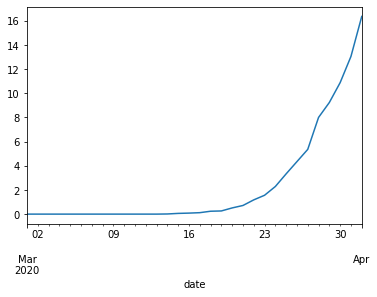

In [215]:
df_ny[df_ny.county == ny_counties[0]].deaths_norm.plot()
#df_ny[df_ny.county == ny_counties[0]].cases_norm.plot()
#pl.legend(['deaths', 'cases'])

In [216]:
df_deaths = df_ny[(df_ny.county == ny_counties[0])&(df_ny.index>='2020-03-14')]

In [217]:
numpy.polyfit(list(map(lambda x: x, range(1,len(df_deaths)+1))), 
               numpy.log(df_deaths.deaths_norm), 1, 
               w=numpy.sqrt(df_deaths.deaths_norm))

array([ 0.26293546, -2.08698413])

In [218]:
 numpy.polyfit(list(map(lambda x: x, range(1,len(df_ny[df_ny.county == ny_counties[0]])+1))), 
               numpy.log(df_ny[df_ny.county == ny_counties[0]].cases_norm), 1, 
               w=numpy.sqrt(df_ny[df_ny.county == ny_counties[0]].cases_norm))

array([ 0.26682202, -1.41976082])

In [219]:
list(map(lambda x: 10**x, range(-2,4)))

[0.01, 0.1, 1, 10, 100, 1000]

In [220]:
color = ['blue', 'dodgerblue', 'midnightblue', 'deeppink', 'grey', 'orange', 'green', 'red', 'purple', 'black']

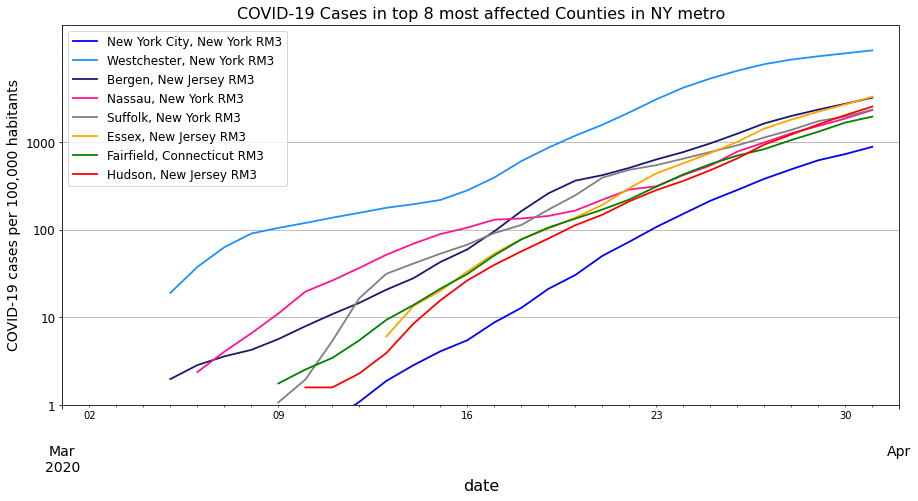

In [221]:
pl.figure(figsize=(15,7))
top=8
for i in range(0, top):
    df_ny[(df_ny.county==ny_counties[i])&(df_ny.cases>0)&(df_ny.state==ny_states[i])].cases_norm_log10.rolling(3, 
                                                    center=True).mean().plot(linewidth=1.8, color=color[i])
pl.legend(list(map(lambda x,y: x+', '+y+' RM3', ny_counties[:top], ny_states[:top])), fontsize=12)
pl.ylabel('COVID-19 cases per 100,000 habitants', fontsize=14)
pl.yticks(range(-2,4,1), list(map(lambda x: str(10**x), range(-2,4))), fontsize=12)
pl.xticks(fontsize=14)
pl.grid('--')
pl.xlabel('date',fontsize=16)
pl.title('COVID-19 Cases in top '+str(top)+' most affected Counties in NY metro', fontsize=16)
#pl.yticks(range(0,4), ['1', '10', '100', '1000', '10,000'])
pl.ylim(0,)
pl.xlim(pd.to_datetime('2020-03-01'),)
pl.savefig('covid_cases.png', dpi=300, bbox_inches = 'tight');

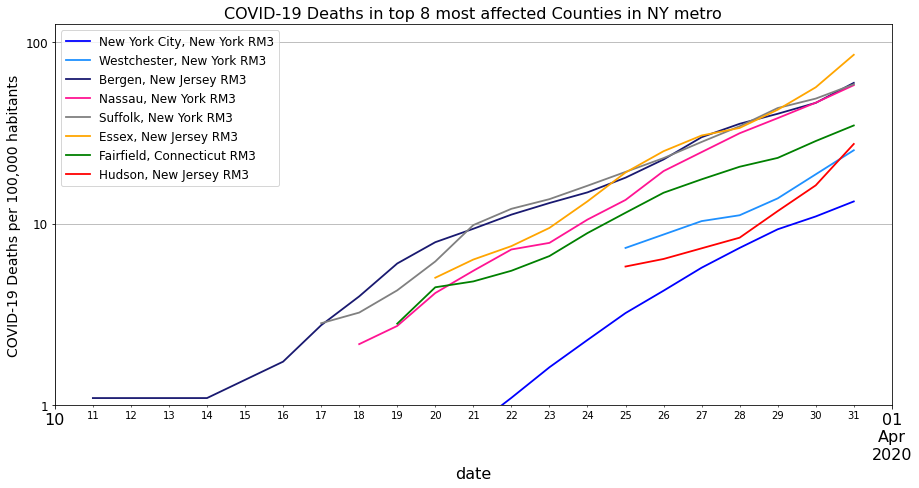

In [222]:
pl.figure(figsize=(15,7))
for i in range(0,top):
    df_ny[(df_ny.county==ny_counties[i])&(df_ny.deaths>0)&(df_ny.state==ny_states[i])].deaths_norm_log10.rolling(3, 
                                                    center=True).mean().plot(linewidth=1.8, color=color[i])
pl.legend(list(map(lambda x,y: x+', '+y+' RM3', ny_counties[:top], ny_states[:top])), fontsize=12)
pl.ylabel('COVID-19 Deaths per 100,000 habitants', fontsize=14)
pl.yticks(range(-2,2,1), list(map(lambda x: str(10**x), range(-2,2))), fontsize=12)
pl.xticks(fontsize=16)
pl.grid('--')
pl.xlabel('date',fontsize=16)
pl.title('COVID-19 Deaths in top '+str(top)+' most affected Counties in NY metro', fontsize=16)
pl.yticks(range(0,3), ['1', '10', '100', '1000'])
pl.ylim(0,)
pl.savefig('covid_deaths.png', dpi=300, bbox_inches = 'tight');

pl.figure(figsize=(20,10))
for i in range(0,5):
    df_ny[(df_ny.county==ny_counties[i])&(df_ny.cases>0)].cases_norm.plot()
pl.legend(ny_counties[:5])
pl.ylabel('COVID-19 cases per 100,000 habitants', fontsize=14)
#pl.yticks(range(-2,4,1), list(map(lambda x: str(10**x), range(-2,4))), fontsize=12)
pl.xticks(fontsize=14)
pl.grid('--');

(0.0, 1.627906976744186)

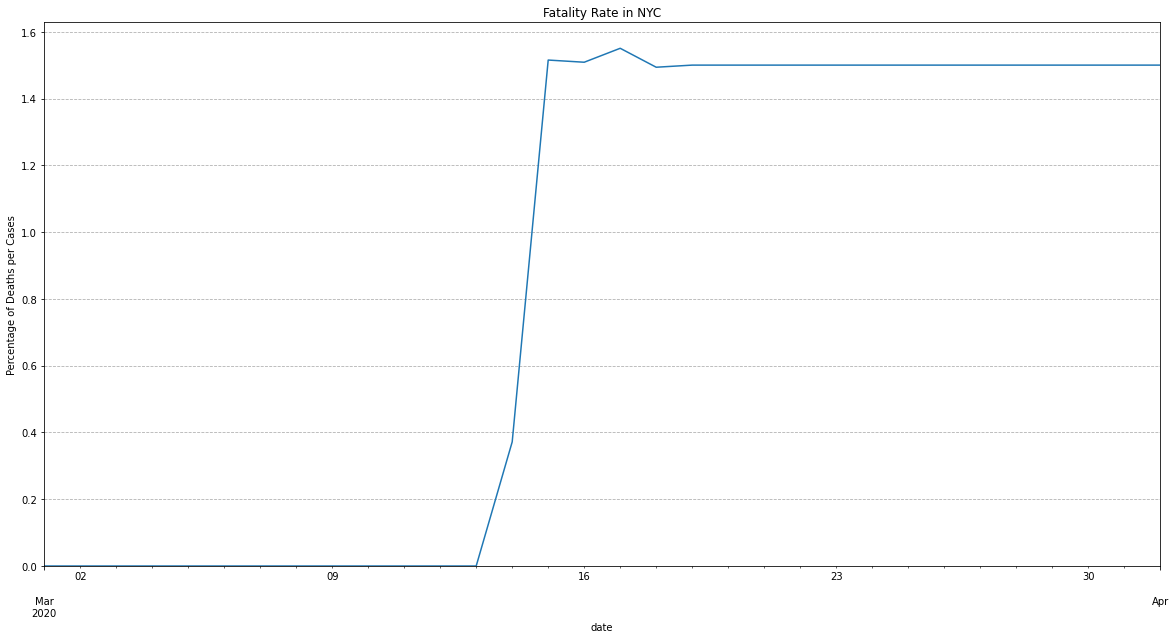

In [223]:
(df_ny[df_ny.county=='New York City']['deaths']*100/df_ny[df_ny.county=='New York City']['cases']).plot(figsize=(20,10))
pl.title('Fatality Rate in NYC')
pl.grid(linestyle='--', axis='y')
pl.ylabel('Percentage of Deaths per Cases')
pl.ylim(0,)
#pl.xticks(range(0,30,1))

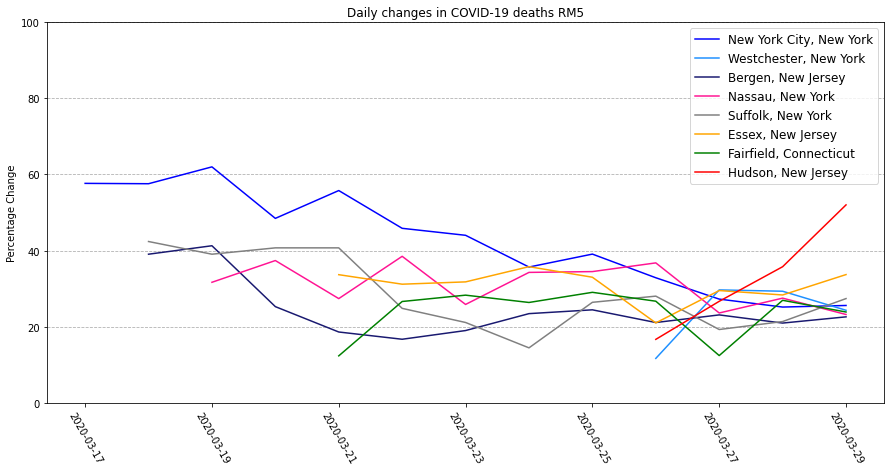

In [224]:
l=[]
pl.figure(figsize=(15,7))
for i in range(0, top):
    death = df_ny[(df_ny.county==ny_counties[i])&(df_ny.deaths>1)&(df_ny.state==ny_states[i])].deaths
    d = list(death)
    if len(d)>0:
        l.append(i)
        pl.plot(death.index[:-1], 
    pd.Series(list(map(lambda x: d[x+1]*100/d[x]-100, range(len(d)-1)))).rolling(5, center=True).mean(), color=color[i])
    else: pass  
pl.legend(list(map(lambda x,y: x+', '+y, ny_counties[:top], ny_states[:top])), fontsize=12)
pl.ylim(0, 100)
pl.ylabel('Percentage Change')
pl.xticks(rotation=300)
pl.title('Daily changes in COVID-19 deaths RM5')
pl.grid(linestyle='--', axis='y');

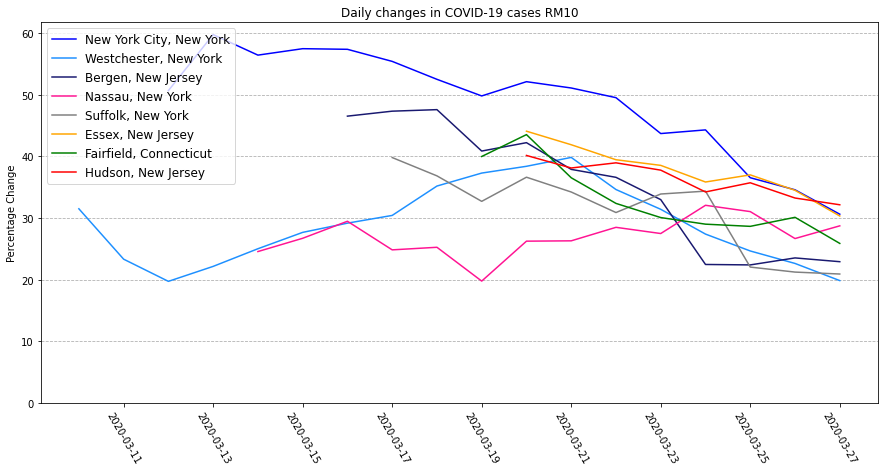

In [225]:
l=[]
pl.figure(figsize=(15, 7))
for i in range(0, top):
    case = df_ny[(df_ny.county==ny_counties[i])&(df_ny.cases>=10)&(df_ny.state==ny_states[i])].cases
    c = list(case)
    if len(c)>0:
        l.append(i)
        pl.plot(case.index[:-1],
        pd.Series(list(map(lambda x: c[x+1]*100/c[x]-100, range(len(c)-1)))).rolling(10, 
                                                    center=True).mean(), color=color[i])      
    else: pass  
pl.legend(list(map(lambda x,y: x+', '+y, ny_counties[:top], ny_states[:top])), fontsize=12)
pl.ylim(0,)
pl.ylabel('Percentage Change')
pl.xticks(rotation=300)
pl.title('Daily changes in COVID-19 cases RM10')
pl.grid(linestyle='--', axis='y');

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarn

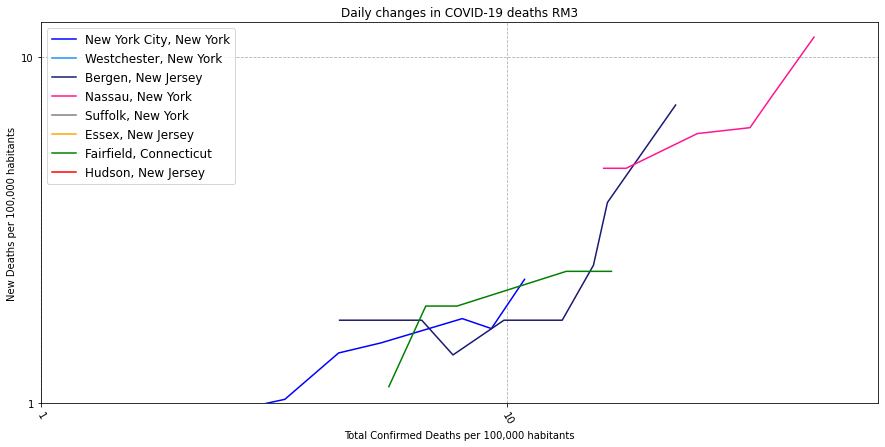

In [226]:
l=[]
pl.figure(figsize=(15,7))
for i in range(0, top):
    death = df_ny[(df_ny.county==ny_counties[i])&(df_ny.deaths>1)].deaths_norm
    d = list(death)
    if len(d)>0:
        l.append(i)
        pl.plot(list(np.log10(death))[:-1], 
            pd.Series(list(map(lambda x: np.log10(d[x+1]-d[x]), range(len(d)-1)))).rolling(3, center=True).mean(),
               color=color[i])
    else: pass  
pl.legend(list(map(lambda x,y: x+', '+y, ny_counties[:top], ny_states[:top])), fontsize=12)
pl.ylim(0,1.1)
pl.ylabel('New Deaths per 100,000 habitants')
pl.xlabel('Total Confirmed Deaths per 100,000 habitants')
pl.xticks(rotation=300)
pl.xlim(0,)
pl.xticks(range(0,2), ['1', '10', '100'])
pl.yticks(range(0,2), ['1', '10', '100'])
pl.title('Daily changes in COVID-19 deaths RM3')
pl.grid(linestyle='--');

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarn

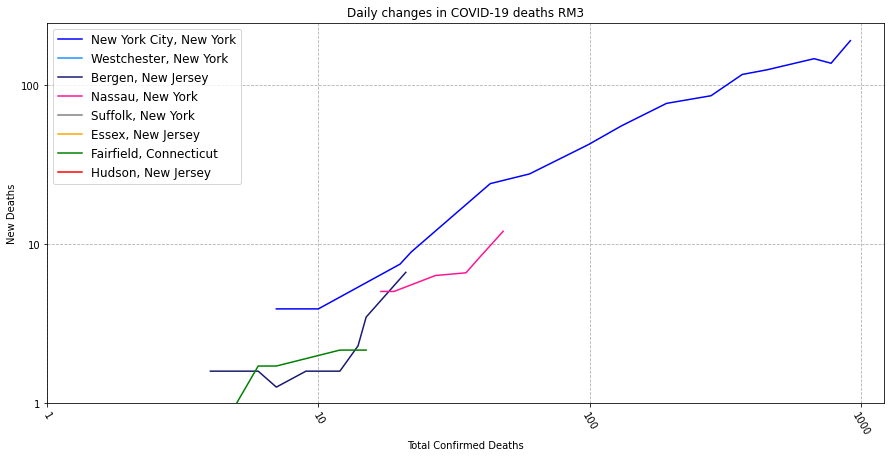

In [227]:
l=[]
pl.figure(figsize=(15,7))
for i in range(0, top):
    death = df_ny[(df_ny.county==ny_counties[i])&(df_ny.deaths>1)].deaths
    d = list(death)
    if len(d)>0:
        l.append(i)
        pl.plot(list(np.log10(death))[:-1], 
            pd.Series(list(map(lambda x: np.log10(d[x+1]-d[x]), range(len(d)-1)))).rolling(3, center=True).mean(),
               color=color[i])
    else: pass  
pl.legend(list(map(lambda x,y: x+', '+y, ny_counties[:top], ny_states[:top])), fontsize=12)
pl.ylim(0,)
pl.ylabel('New Deaths')
pl.xlabel('Total Confirmed Deaths')
pl.xticks(rotation=300)
pl.title('Daily changes in COVID-19 deaths RM3')
pl.grid(linestyle='--')
pl.xticks(range(0,4), ['1', '10', '100', '1000'])
pl.yticks(range(0,3), ['1', '10', '100']);

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


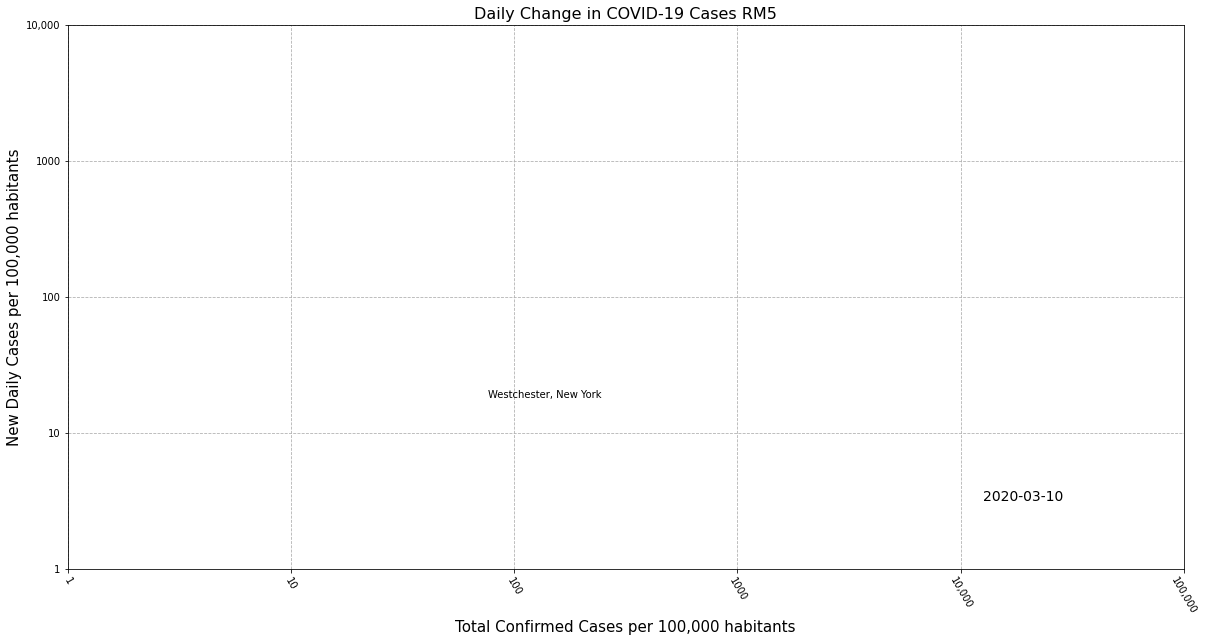

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


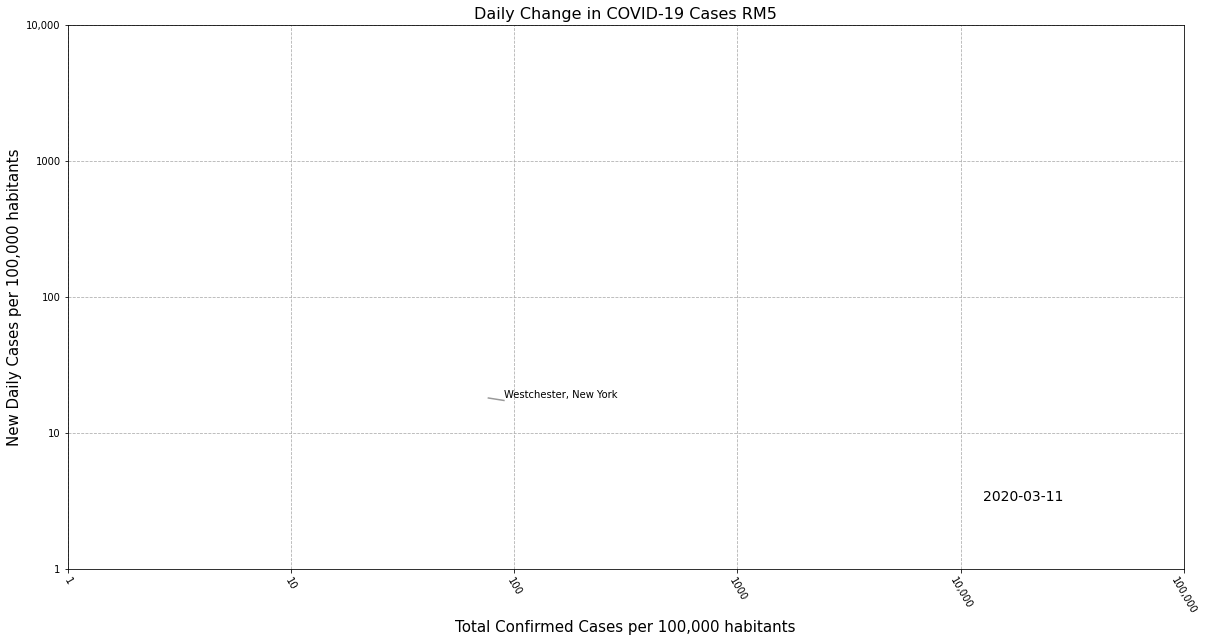

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


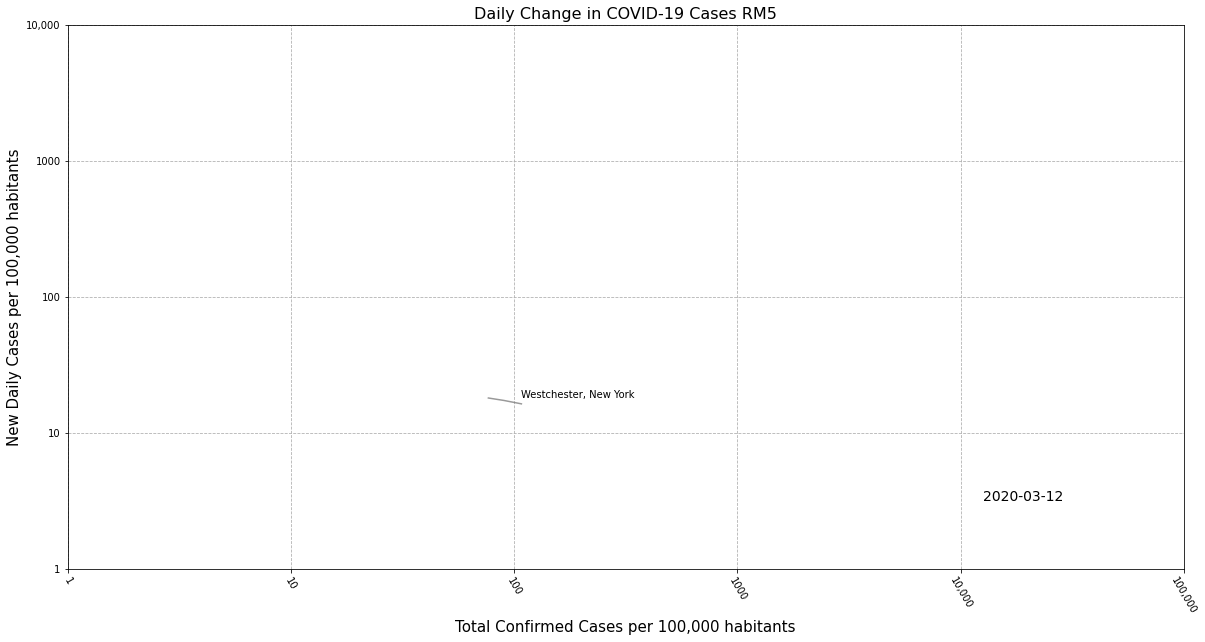

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


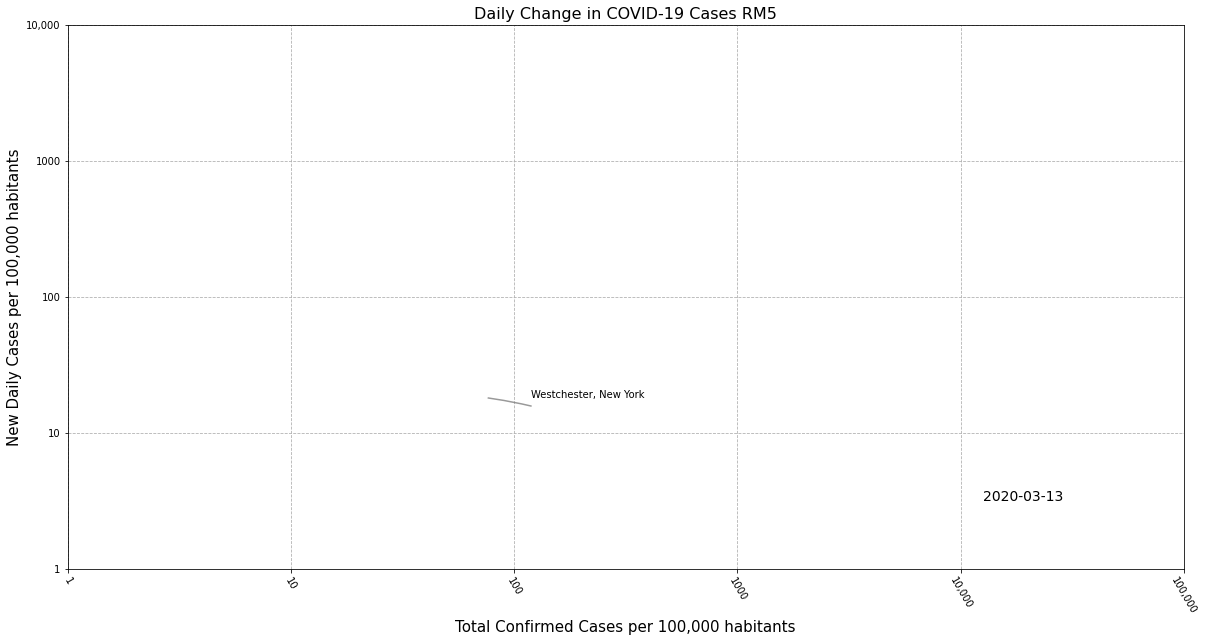

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


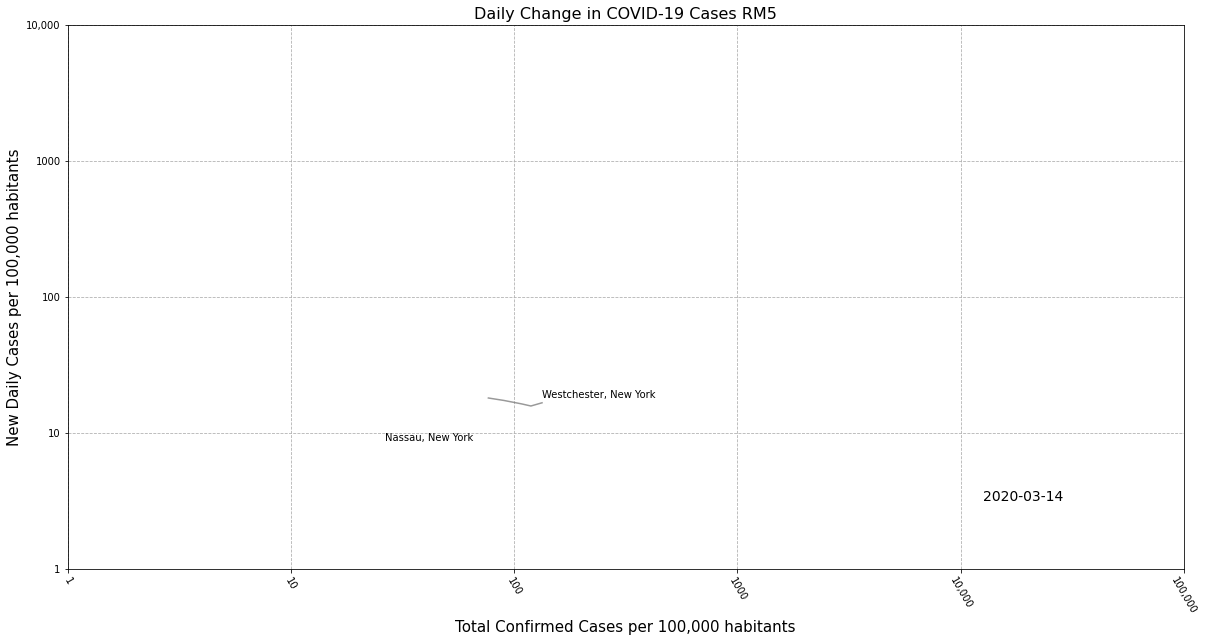

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


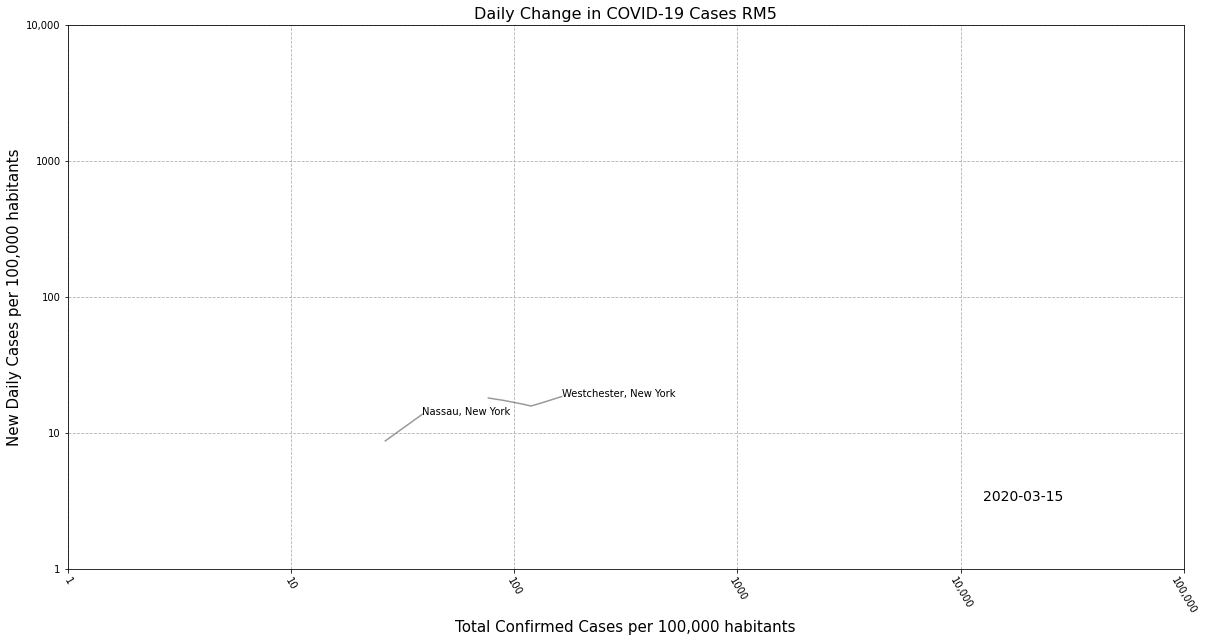

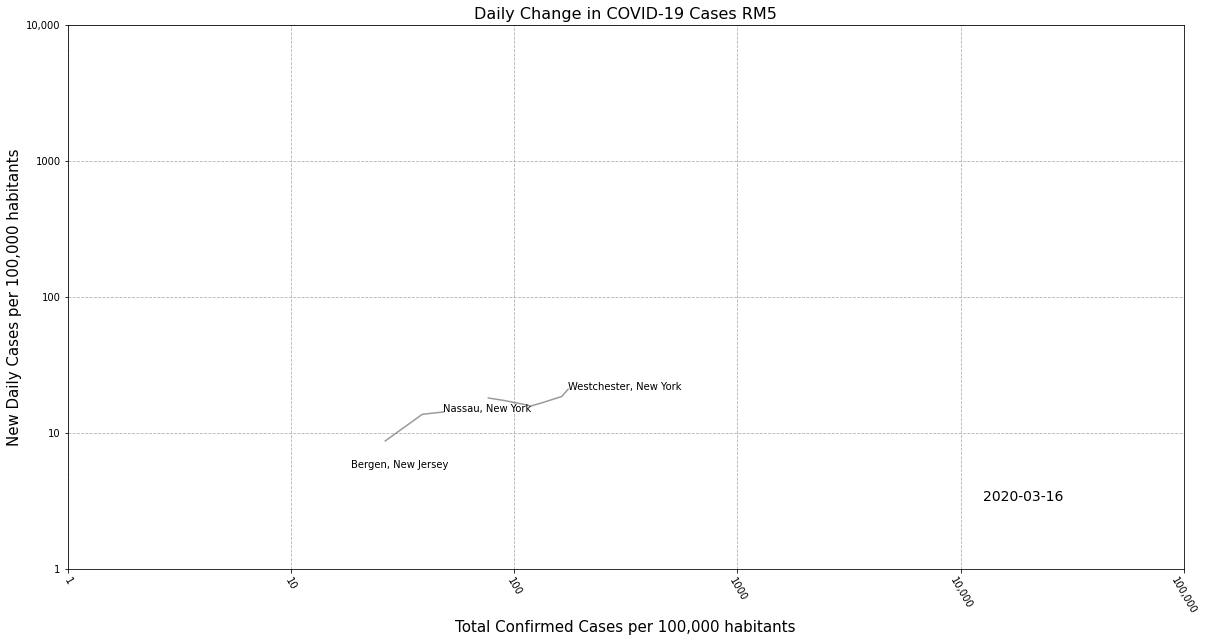

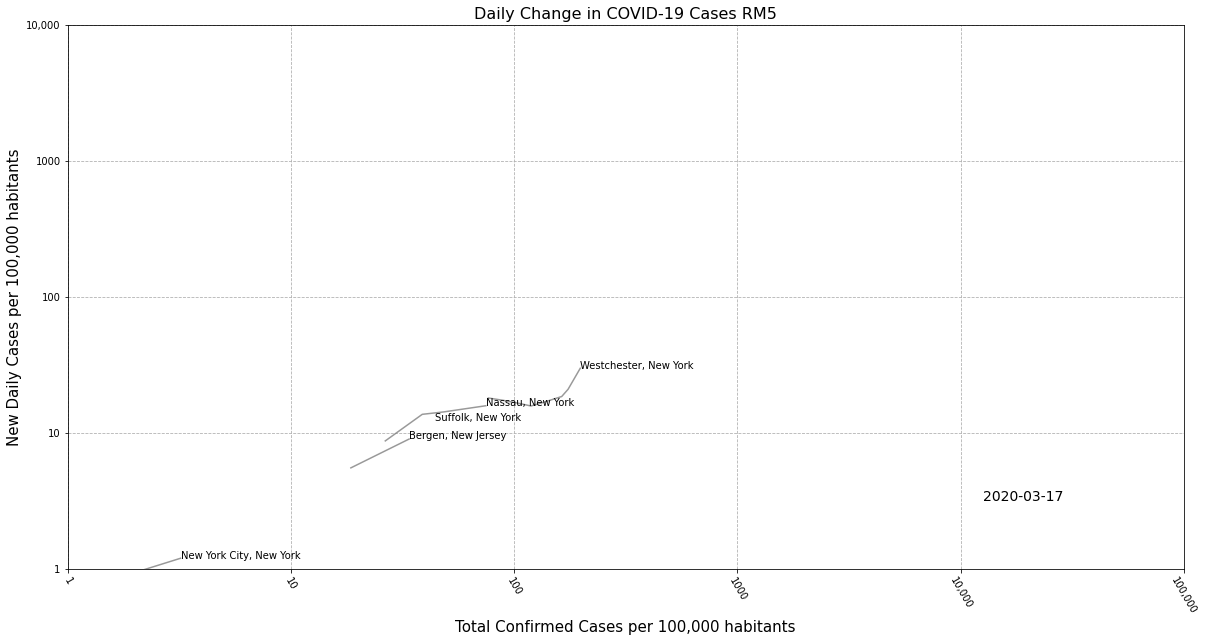

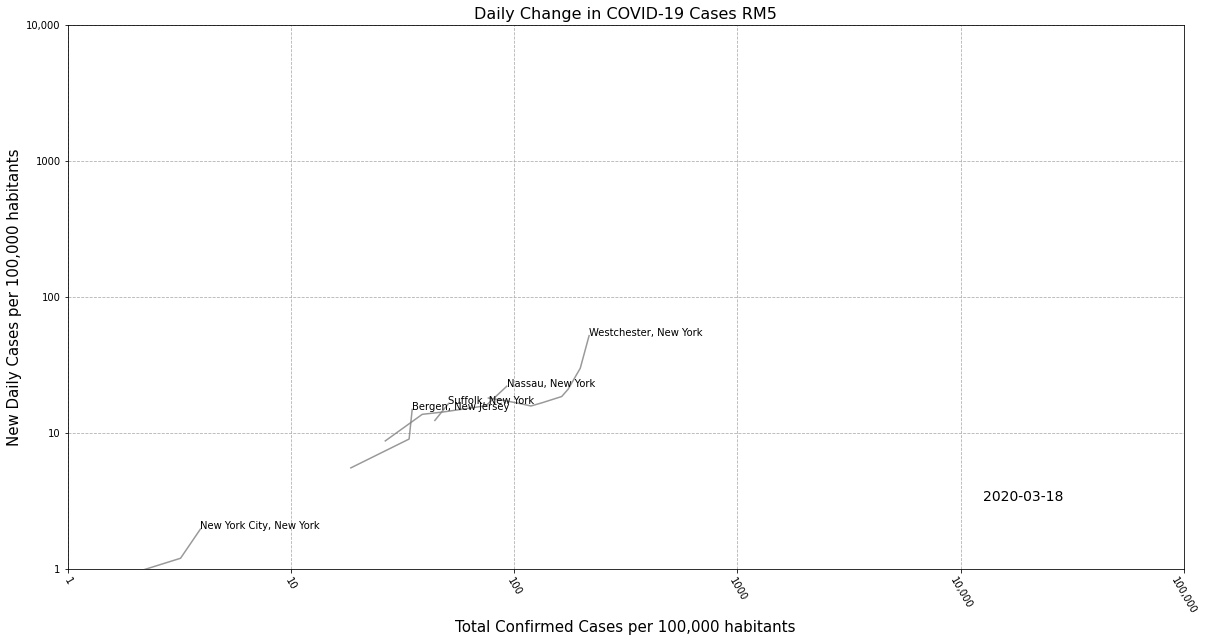

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


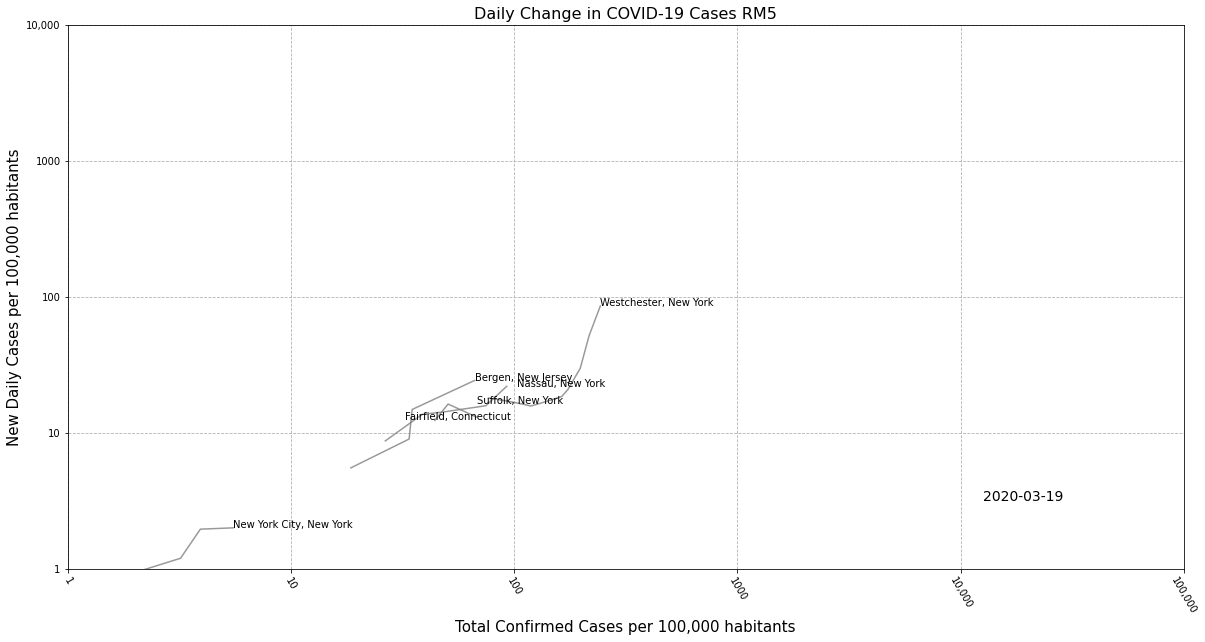

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


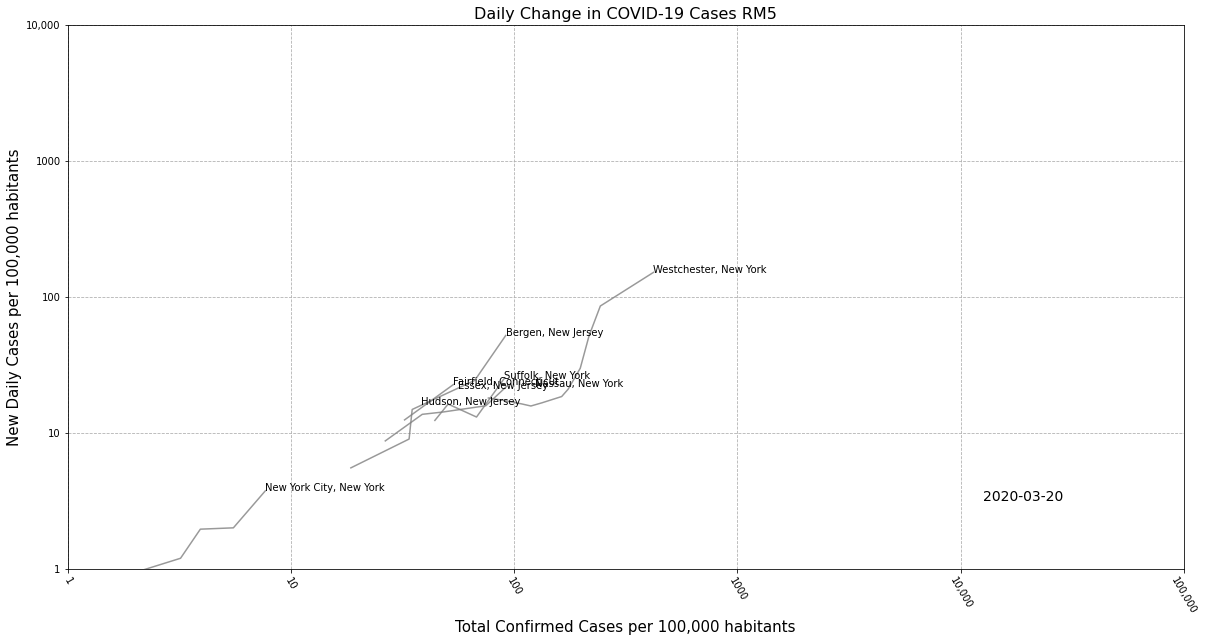

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


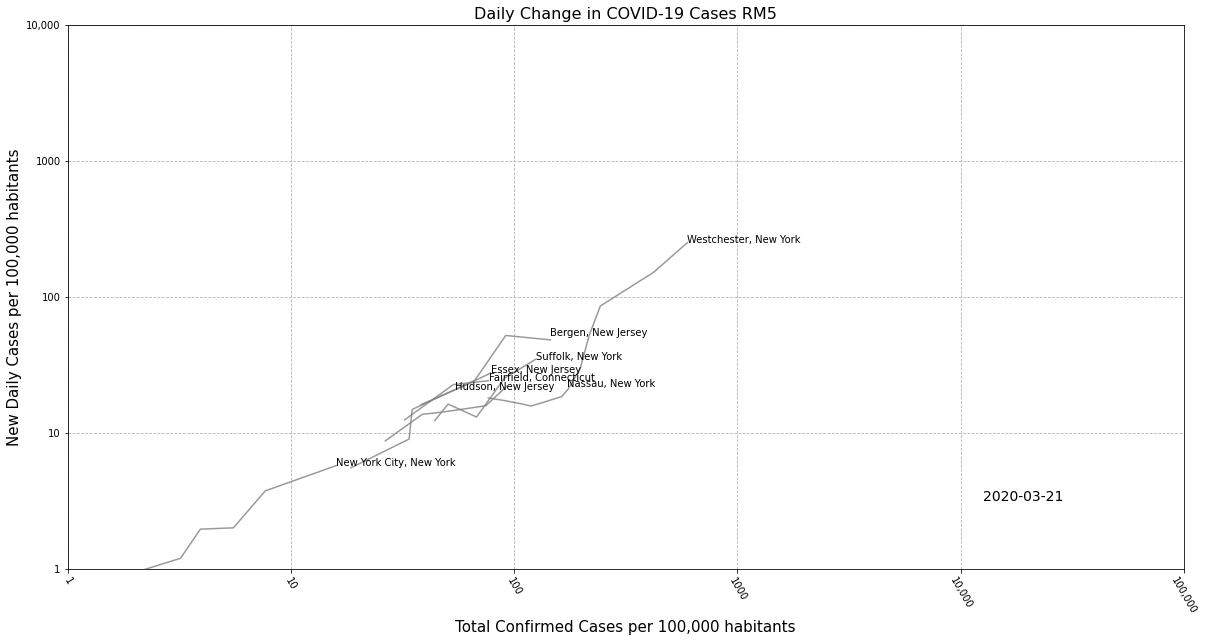

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


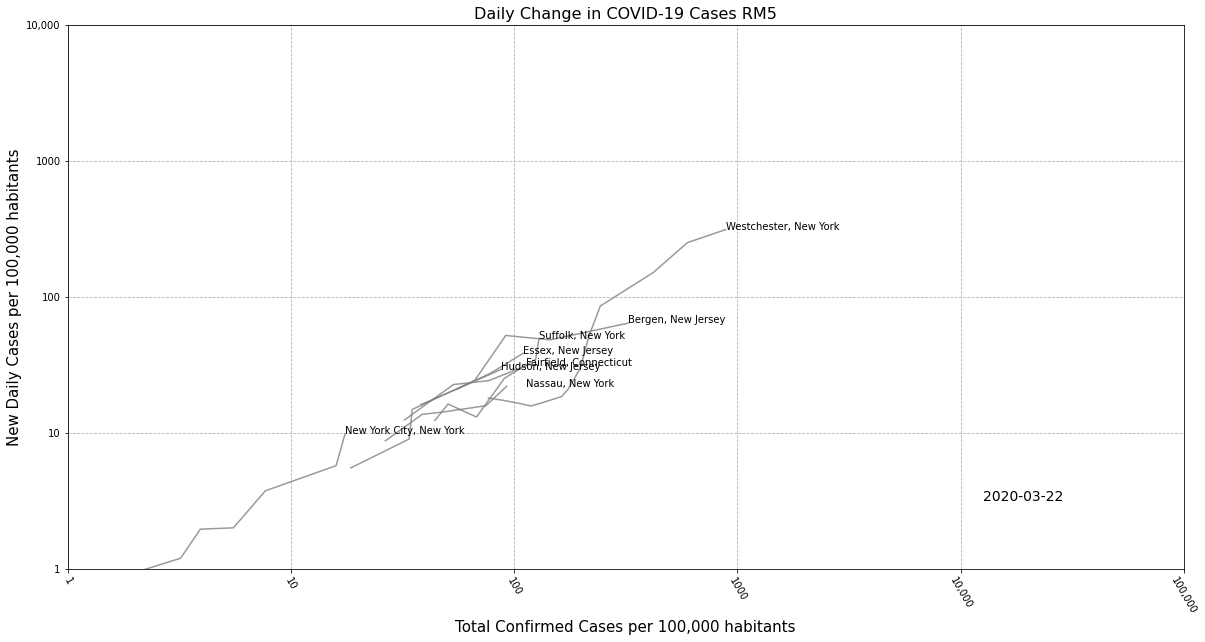

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


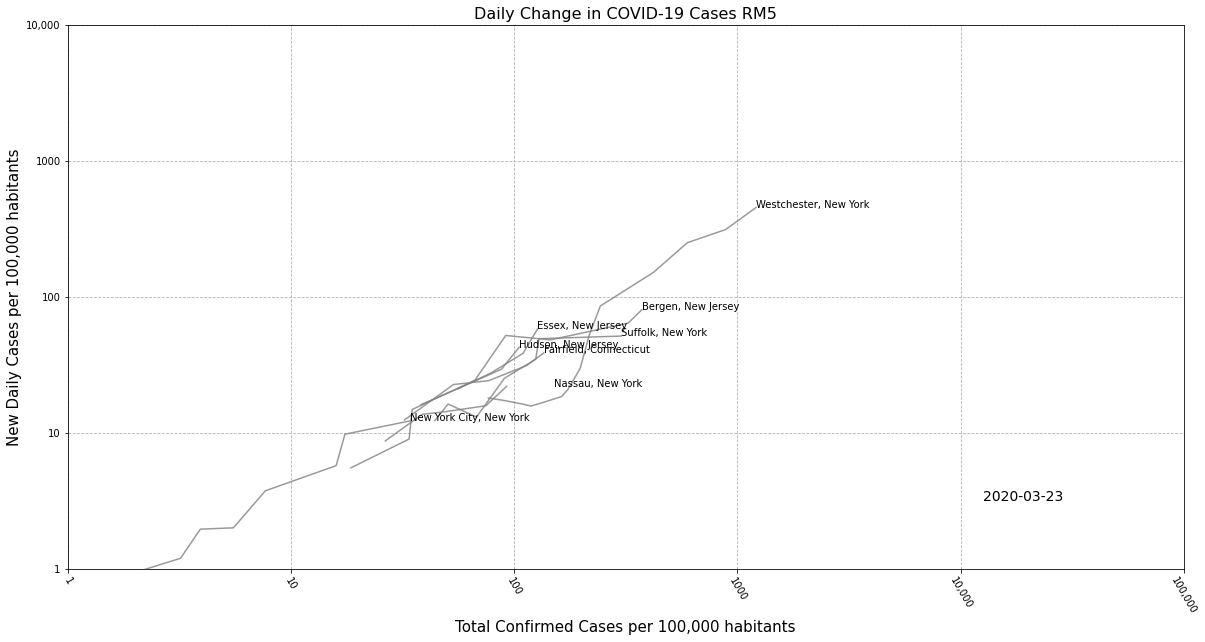

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


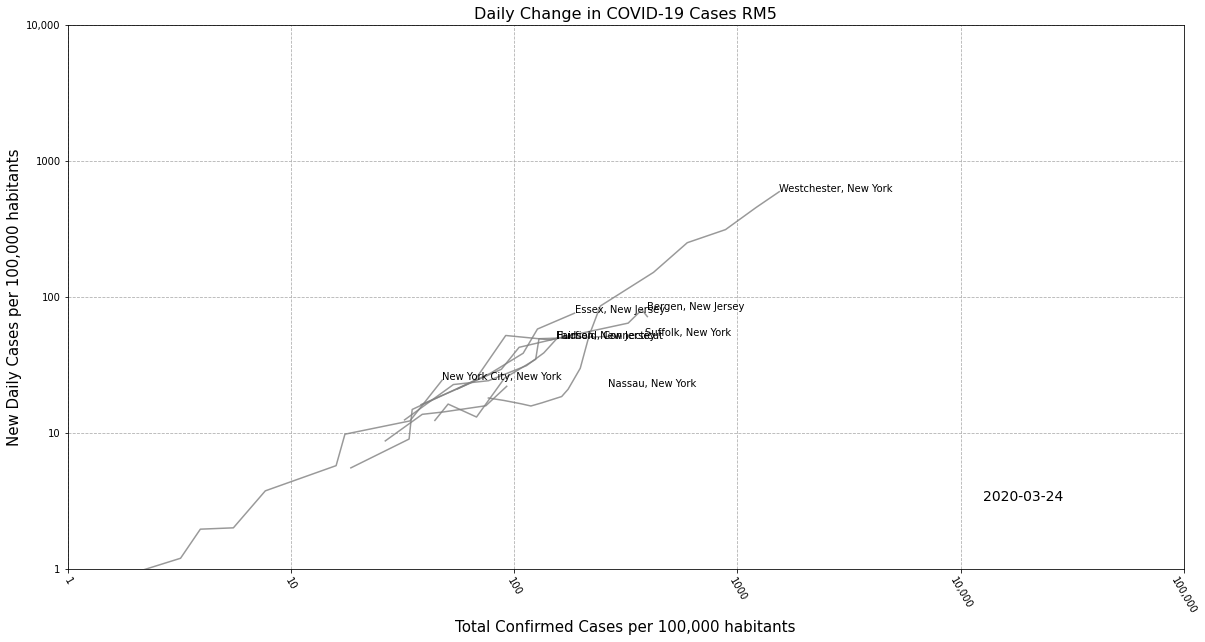

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


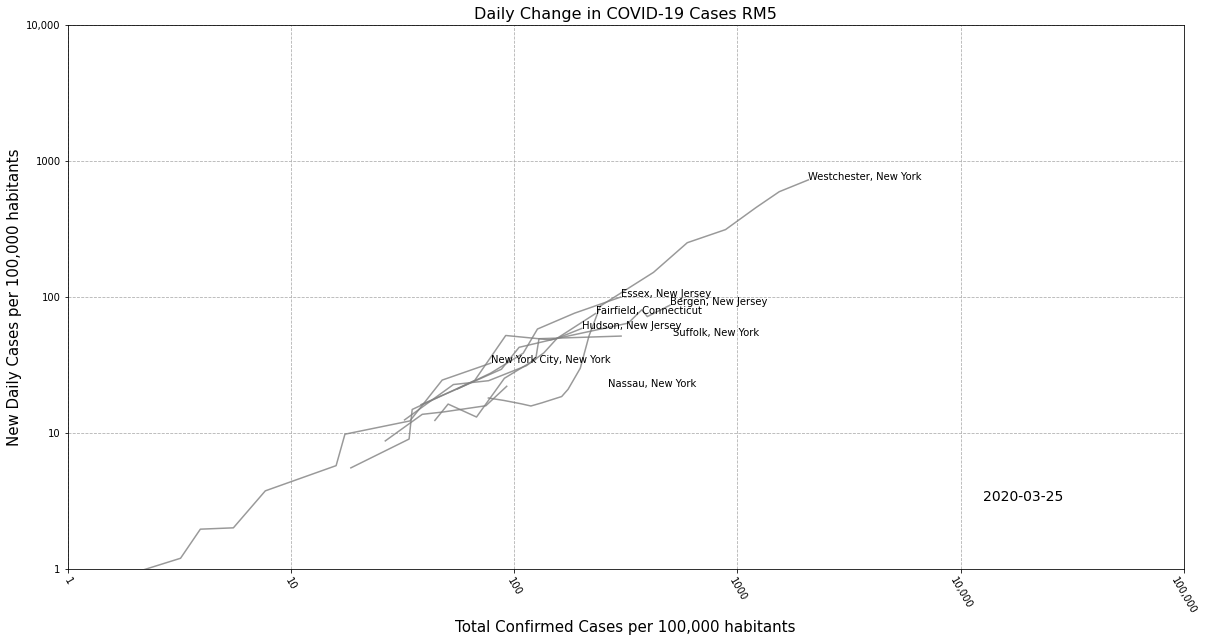

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


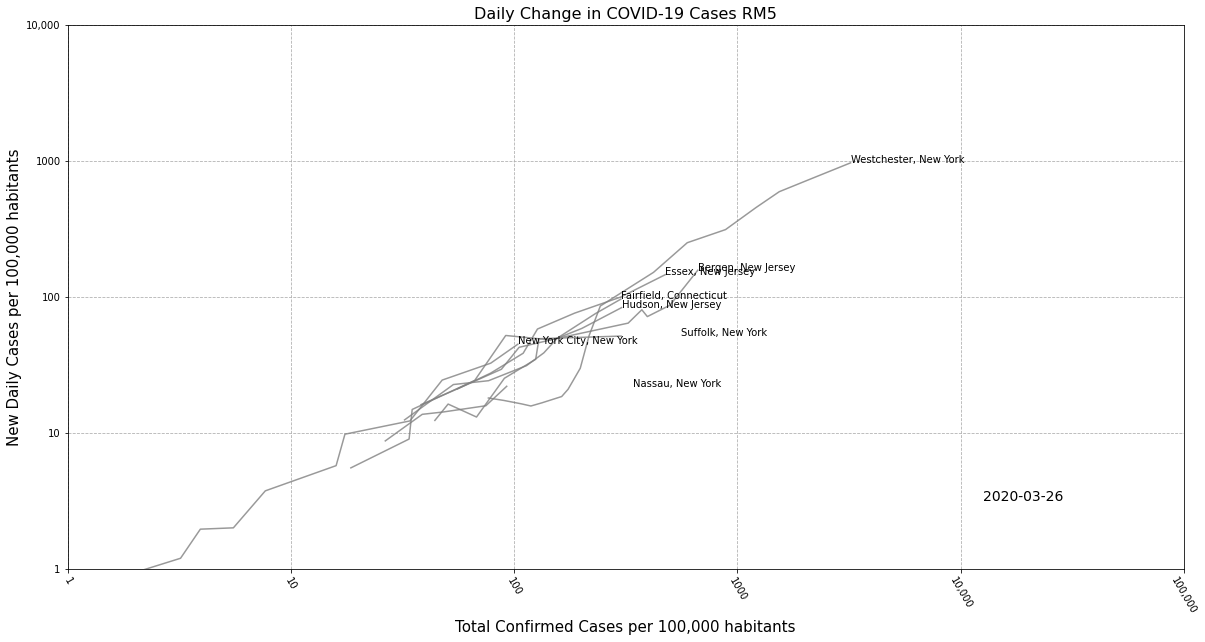

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


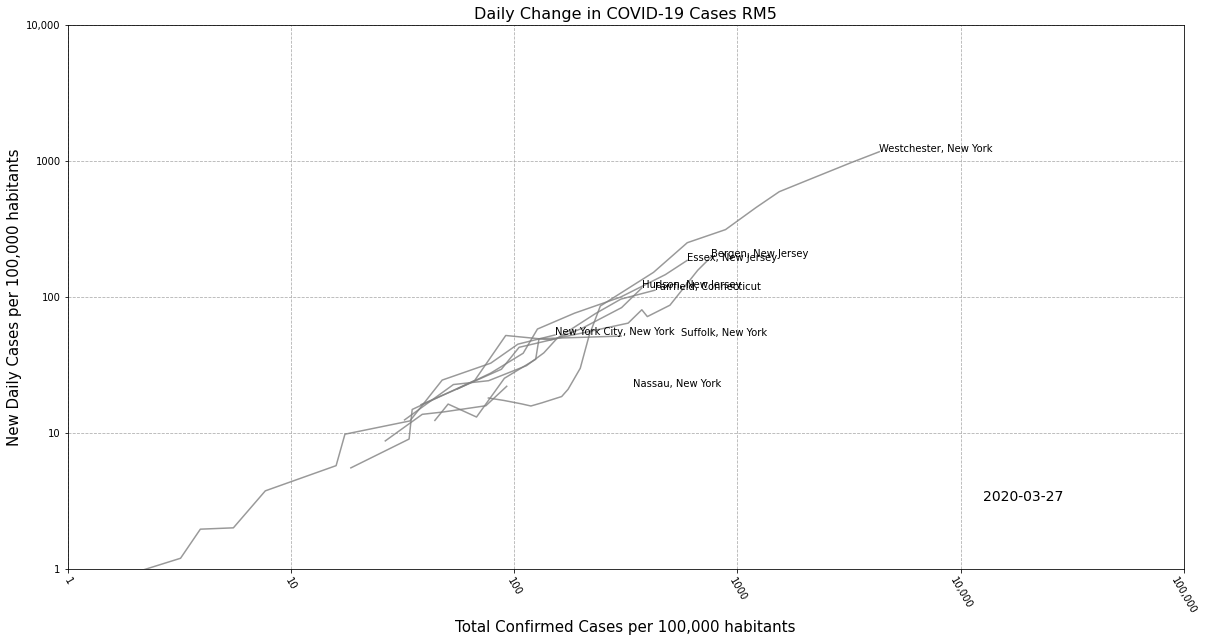

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


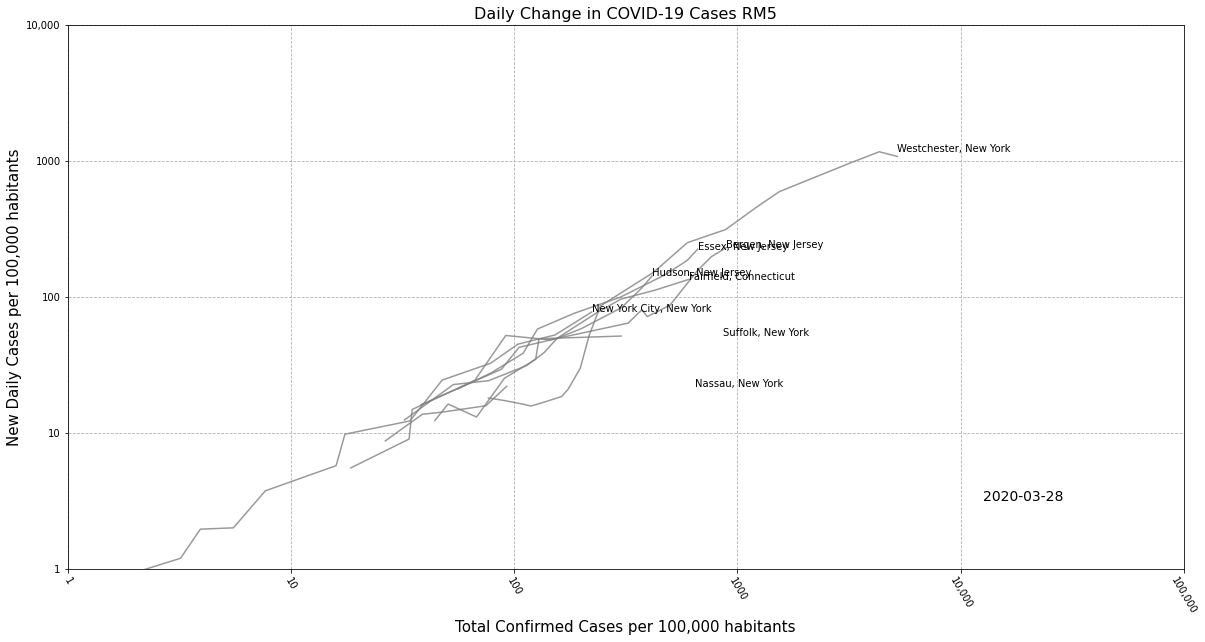

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


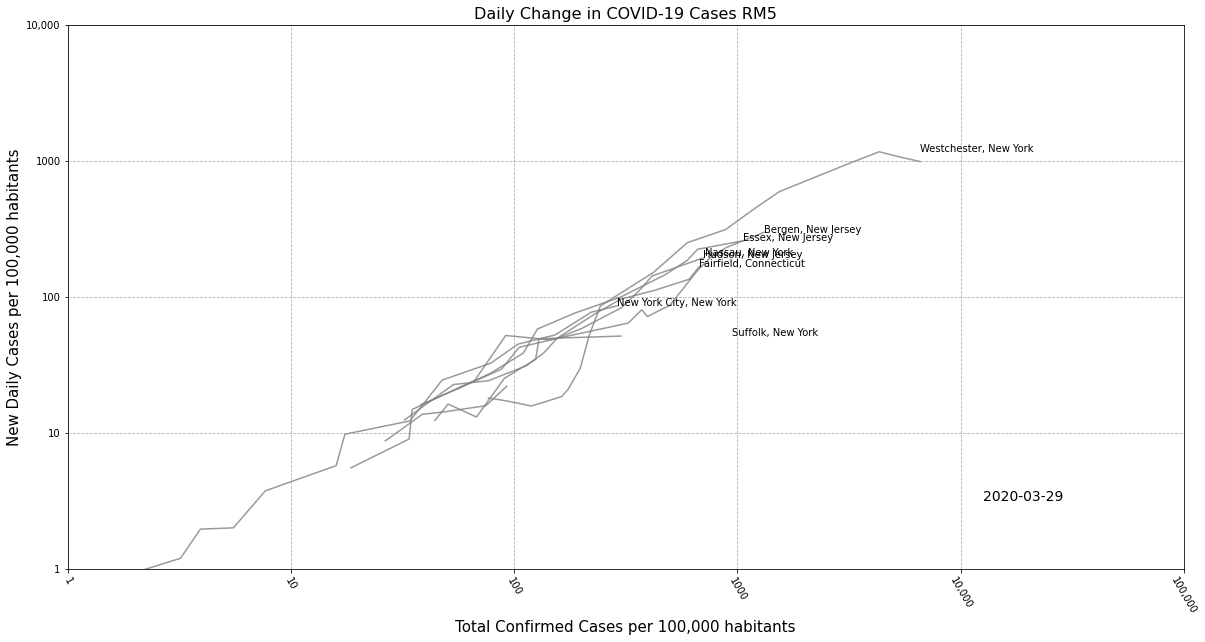

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


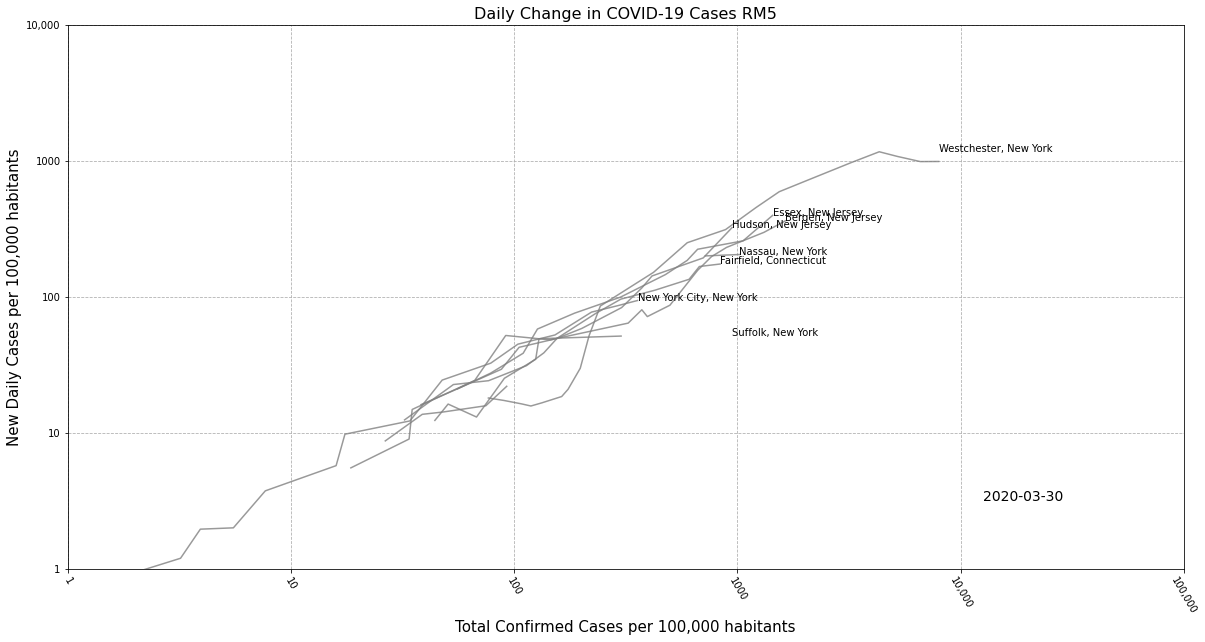

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


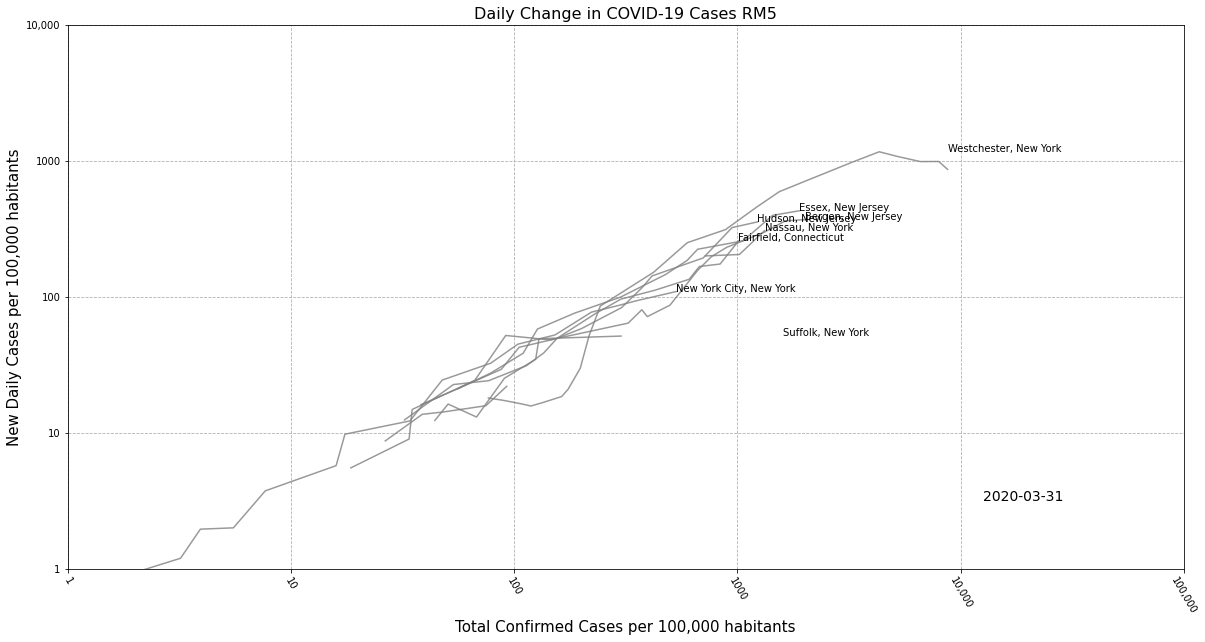

In [235]:
l=[]
for j in range(49,len(dates)):
    pl.figure(figsize=(20, 10))
    for i in range(0, top):
        case = df_ny[(df_ny.county==ny_counties[i])&(df_ny.cases>=10)&(df_ny.state==ny_states[i])&(df_ny.index<=dates[j])]\
                                    .cases_norm
        c = list(case)
        series = pd.Series(list(map(lambda x: np.log10(c[x+1]-c[x]), range(len(c)-1))))
        if (len(series)>4)&(series.rolling(5, center=True).mean().max()>0):
            l.append(i)
            pl.plot(list(np.log10(case))[:-1], series.rolling(5, 
                                                    center=True).mean(), color='grey', alpha=0.8)
            pl.text(list(np.log10(case))[-4], series.rolling(5, 
                                                    center=True).mean().max(), ny_counties[i]+', '+ny_states[i])
            pl.ylim(0,4)
            pl.xlim(0,)
            pl.ylabel('New Daily Cases per 100,000 habitants', fontsize=15)
            pl.xlabel('Total Confirmed Cases per 100,000 habitants', fontsize=15)
            pl.xticks(rotation=300)
            pl.title('Daily Change in COVID-19 Cases RM5', fontsize=16)
            pl.grid(linestyle='--')
            pl.xticks(range(0,6), ['1', '10', '100', '1000', '10,000', '100,000']);
            pl.yticks(range(0,5), ['1', '10', '100', '1000', '10,000', '100,000'])
        else: pass
    pl.text(4.1,0.5, str(dates[j])[:10], fontsize=14)
    pl.savefig('viz/log_animation/'+str(dates[j])[:10]+'.png', dpi=300, bbox_inches = 'tight');
    pl.show()
    
#pl.legend(list(map(lambda x,y: x+', '+y, ny_counties[:top], ny_states[:top])), fontsize=12)

l=[]
pl.figure(figsize=(15, 7))
for i in range(0, top):
    case = df_ny[(df_ny.county==ny_counties[i])&(df_ny.cases>=10)].cases
    c = list(case)
    if len(c)>0:
        l.append(i)
        pl.plot(list(np.log10(case))[:-1],
        pd.Series(list(map(lambda x: np.log10(c[x+1]-c[x]), range(len(c)-1)))).rolling(5, 
                                                    center=True).mean(), color=color[i])      
    else: pass  
pl.legend(list(map(lambda x,y: x+', '+y, ny_counties[:top], ny_states[:top])), fontsize=12)
pl.ylim(0,)
pl.ylabel('New Cases')
pl.xlabel('Total Confirmed Cases')
pl.xticks(rotation=300)
pl.title('Daily changes in COVID-19 Cases RM5')
pl.xticks(range(0,6), ['1', '10', '100', '1000', '10,000', '100,000'])
pl.yticks(range(0,5), ['1', '10', '100', '1000', '10,000', '100,000'])
pl.grid(linestyle='--');

### Other States/Counties

In [42]:
df_covid = df_covid[df_covid.county!='Unknown']

In [43]:
fips = list(df_covid[df_covid.date==df_covid.date.max()].sort_values('cases', ascending=False).fips)
states = list(df_covid[df_covid.date==df_covid.date.max()].sort_values('cases', ascending=False).state)
counties = list(df_covid[df_covid.date==df_covid.date.max()].sort_values('cases', ascending=False).county)

In [44]:
df_covid['cases_norm'] = df_covid.cases*100000/df_covid['pop']
df_covid['deaths_norm'] = df_covid.deaths*100000/df_covid['pop']
df_covid['cases_norm_log10'] = np.log10(df_covid.cases_norm)
df_covid['deaths_norm_log10'] = np.log10(df_covid.deaths_norm)
df_covid.index = df_covid.date
df_covid = df_covid.drop('date', axis=1)
df_covid['fat_rate'] = df_covid.deaths_norm*100/df_covid.cases_norm

/home/sptkl/.local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [45]:
df_covid.head()

,county,state,fips,cases,deaths,pop,cases_norm,deaths_norm,cases_norm_log10,deaths_norm_log10,fat_rate
date,,,,,,,,,,,
2020-01-21,Snohomish,Washington,53061,1.0,0,78020.0,1.281723,0.0,0.107794,-inf,0.0
2020-01-22,Snohomish,Washington,53061,1.0,0,78020.0,1.281723,0.0,0.107794,-inf,0.0
2020-01-23,Snohomish,Washington,53061,1.0,0,78020.0,1.281723,0.0,0.107794,-inf,0.0
2020-01-24,Cook,Illinois,17031,1.0,0,59426.0,1.682765,0.0,0.226024,-inf,0.0
2020-01-24,Snohomish,Washington,53061,1.0,0,78020.0,1.281723,0.0,0.107794,-inf,0.0


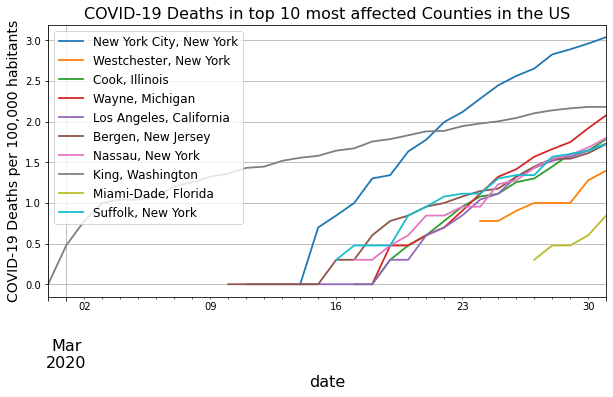

In [46]:
pl.figure(figsize=(10,5))
top=10
for i in range(0,top):
    df_covid[(df_covid.fips==fips[i])&(df_covid.deaths>0)&(df_covid.county==counties[i])]\
    .deaths.apply(lambda x: np.log10(x)).plot(linewidth=1.8)
pl.legend(list(map(lambda x,y: x+', '+y, counties[:top], list(states[:top]))), fontsize=12)
pl.ylabel('COVID-19 Deaths per 100,000 habitants', fontsize=14)
#pl.yticks(range(-2,2,1), list(map(lambda x: str(10**x), range(-2,2))), fontsize=12)
pl.xticks(fontsize=16)
pl.grid('--')
pl.xlabel('date',fontsize=16)
pl.title('COVID-19 Deaths in top '+str(top)+' most affected Counties in the US', fontsize=16)
pl.savefig('covid_deaths.png', dpi=300, bbox_inches = 'tight');

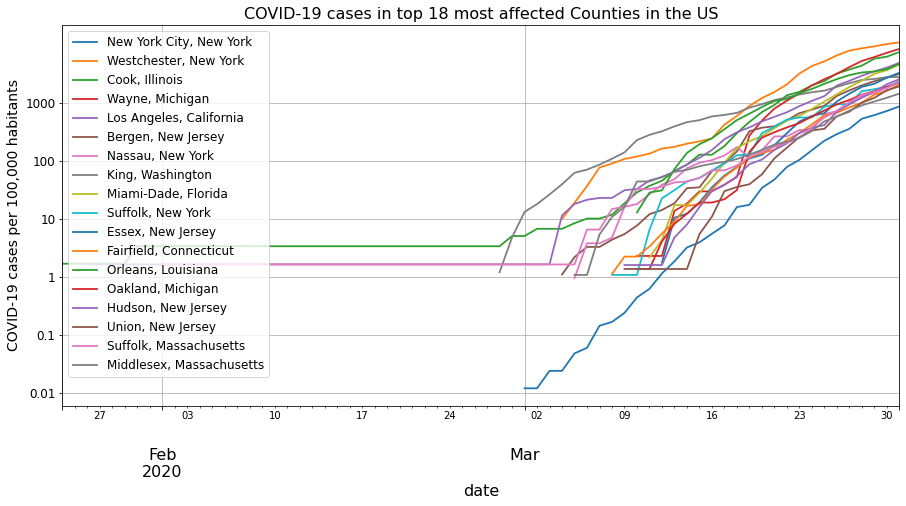

In [47]:
pl.figure(figsize=(15, 7))
top = 18
for i in range(0,top):
    df_covid[(df_covid.fips==fips[i])&(df_covid.cases>0)&(df_covid.county==counties[i])]\
    .cases_norm_log10.plot(linewidth=1.8)
pl.legend(list(map(lambda x,y: x+', '+y, counties[:top], list(states[:top]))), fontsize=12)
pl.ylabel('COVID-19 cases per 100,000 habitants', fontsize=14)
pl.yticks(range(-2,4,1), list(map(lambda x: str(10**x), range(-2,4))), fontsize=12)
pl.xticks(fontsize=16)
pl.grid('--')
pl.xlabel('date',fontsize=16)
pl.title('COVID-19 cases in top '+str(top)+' most affected Counties in the US', fontsize=16)
pl.savefig('covid_cases.png', dpi=300, bbox_inches = 'tight');

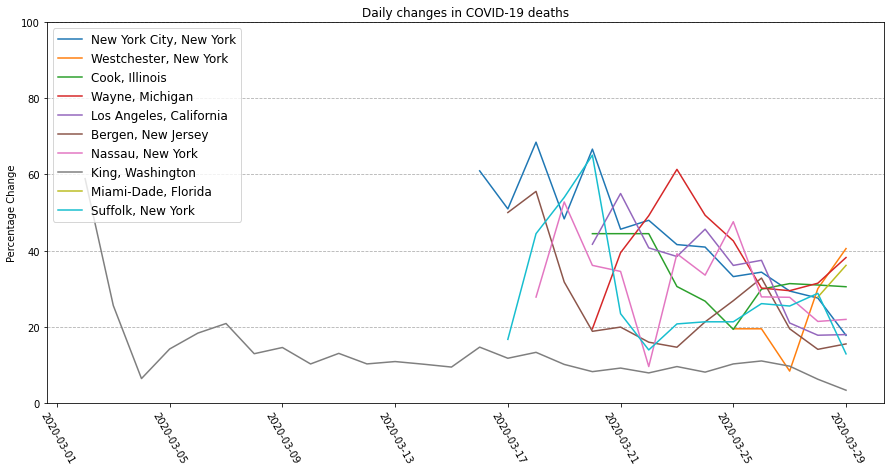

In [48]:
l=[]
pl.figure(figsize=(15,7))
top=10
for i in range(0,top):
    death = df_covid[(df_covid.county==counties[i])&(df_covid.deaths>1)&(df_covid.fips==fips[i])].deaths
    d = list(death)
    if len(d)>0:
        l.append(i)
        pl.plot(death.index[:-1], 
            pd.Series(list(map(lambda x: d[x+1]*100/d[x]-100, range(len(d)-1)))).rolling(3, center=True).mean())
    else: pass  
pl.title('COVID-19 deaths in top '+str(top)+' most affected Counties in the US', fontsize=16)
pl.legend(list(map(lambda x,y: x+', '+y, counties[:top], list(states[:top]))), fontsize=12)
pl.ylim(0,100)
pl.ylabel('Percentage Change')
pl.xticks(rotation=300)
pl.title('Daily changes in COVID-19 deaths')
pl.grid(linestyle='--', axis='y');

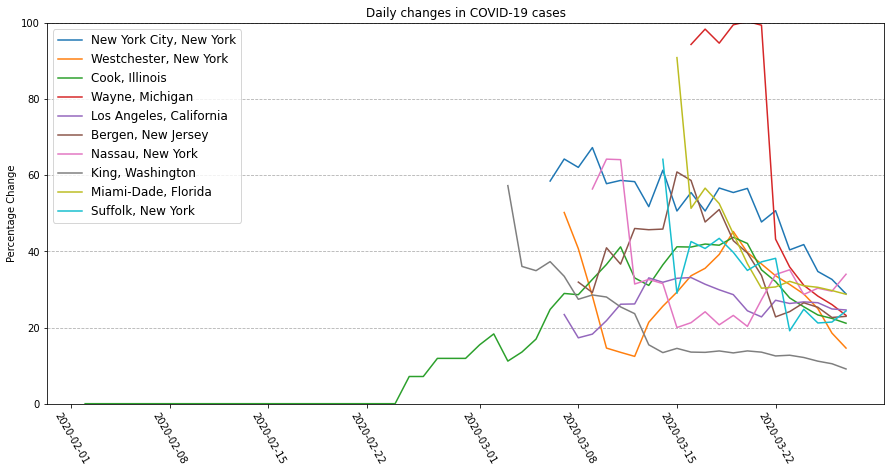

In [49]:
l=[]
pl.figure(figsize=(15,7))
top=10
for i in range(0,top):
    case = df_covid[(df_covid.county==counties[i])&(df_covid.cases>1)&(df_covid.fips==fips[i])].cases
    d = list(case)
    if len(d)>0:
        l.append(i)
        pl.plot(case.index[:-1], 
            pd.Series(list(map(lambda x: d[x+1]*100/d[x]-100, range(len(d)-1)))).rolling(7, center=True).mean())
    else: pass  
pl.title('COVID-19 cases in top '+str(top)+' most affected Counties in the US', fontsize=16)
pl.legend(list(map(lambda x,y: x+', '+y, counties[:top], list(states[:top]))), fontsize=12)
pl.ylim(0,100)
pl.ylabel('Percentage Change')
pl.xticks(rotation=300)
pl.title('Daily changes in COVID-19 cases')
pl.grid(linestyle='--', axis='y');

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero e

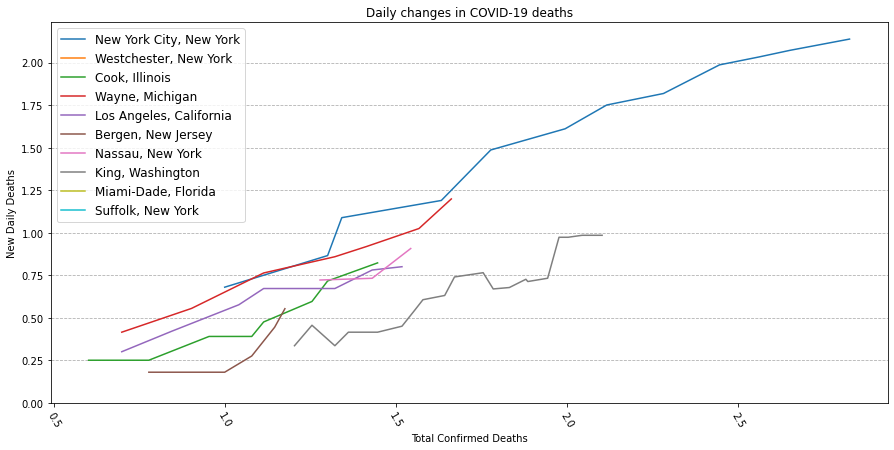

In [50]:
l=[]
pl.figure(figsize=(15,7))
top=10
for i in range(0,top):
    death = df_covid[(df_covid.county==counties[i])&(df_covid.deaths>1)&(df_covid.fips==fips[i])].deaths
    d = list(death)
    if len(d)>0:
        l.append(i)
        pl.plot(list(np.log10(death))[:-1], 
            pd.Series(list(map(lambda x: np.log10(d[x+1]-d[x]), range(len(d)-1)))).rolling(5, center=True).mean())
    else: pass  
pl.title('COVID-19 deaths in top '+str(top)+' most affected Counties in the US', fontsize=16)
pl.legend(list(map(lambda x,y: x+', '+y, counties[:top], list(states[:top]))), fontsize=12)
pl.ylim(0,)
pl.ylabel('New Daily Deaths')
pl.xlabel('Total Confirmed Deaths')
pl.xticks(rotation=300)
pl.title('Daily changes in COVID-19 deaths')
pl.grid(linestyle='--', axis='y');

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero e

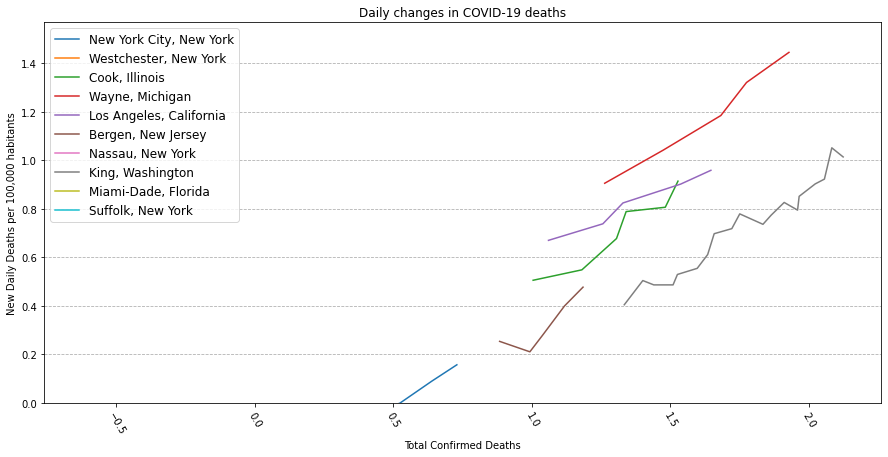

In [71]:
l=[]
pl.figure(figsize=(15,7))
top=10
for i in range(0,top):
    death = df_covid[(df_covid.county==counties[i])&(df_covid.deaths>1)&(df_covid.fips==fips[i])].deaths_norm
    d = list(death)
    if len(d)>0:
        l.append(i)
        pl.plot(list(np.log10(death))[:-1], 
            pd.Series(list(map(lambda x: np.log10(d[x+1]-d[x]), range(len(d)-1)))).rolling(7, center=True).mean())
    else: pass  
pl.title('COVID-19 deaths in top '+str(top)+' most affected Counties in the US', fontsize=16)
pl.legend(list(map(lambda x,y: x+', '+y, counties[:top], list(states[:top]))), fontsize=12)
pl.ylim(0,)
pl.ylabel('New Daily Deaths per 100,000 habitants')
pl.xlabel('Total Confirmed Deaths')
pl.xticks(rotation=300)
pl.title('Daily changes in COVID-19 deaths')
pl.grid(linestyle='--', axis='y');

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero e

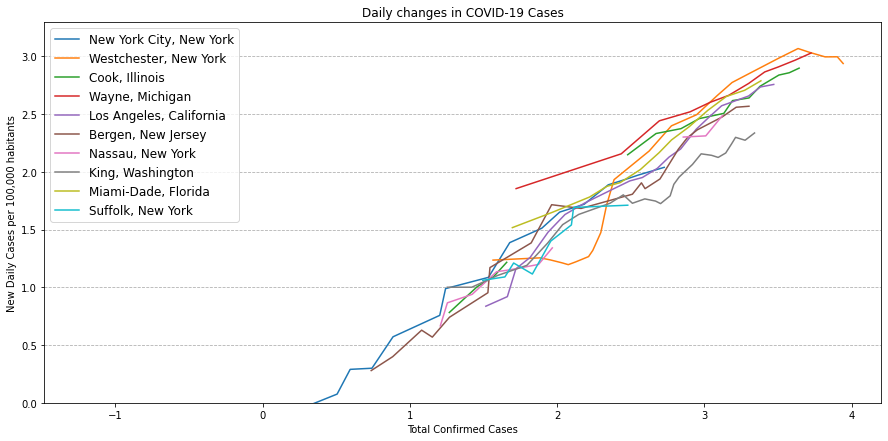

In [52]:
l=[]
pl.figure(figsize=(15,7))
top=10
for i in range(0,top):
    case = df_covid[(df_covid.county==counties[i])&(df_covid.cases>1)&(df_covid.fips==fips[i])].cases_norm
    d = list(case)
    if len(d)>0:
        l.append(i)
        pl.plot(list(np.log10(case))[:-1], 
            pd.Series(list(map(lambda x: np.log10(d[x+1]-d[x]), range(len(d)-1)))).rolling(5, center=True).mean())
    else: pass  
pl.title('COVID-19 cases in top '+str(top)+' most affected Counties in the US', fontsize=16)
pl.legend(list(map(lambda x,y: x+', '+y, counties[:top], list(states[:top]))), fontsize=12)
pl.ylim(0,)
pl.ylabel('New Daily Cases per 100,000 habitants')
pl.xlabel('Total Confirmed Cases')
pl.xticks(rotation=0)
pl.title('Daily changes in COVID-19 Cases')
pl.grid(linestyle='--', axis='y');

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero e

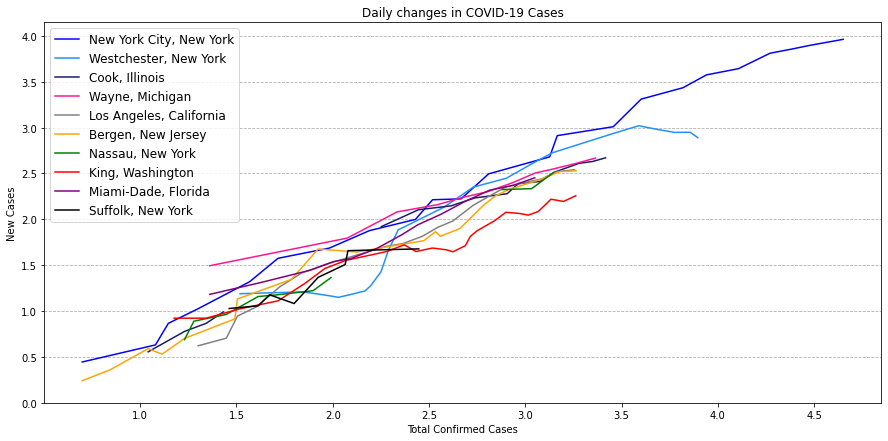

In [76]:
l=[]
pl.figure(figsize=(15,7))
top=10
for i in range(0,top):
    case = df_covid[(df_covid.county==counties[i])&(df_covid.cases>1)&(df_covid.fips==fips[i])].cases
    d = list(case)
    if len(d)>0:
        l.append(i)
        pl.plot(list(np.log10(case))[:-1], 
    pd.Series(list(map(lambda x: np.log10(d[x+1]-d[x]), range(len(d)-1)))).rolling(5, center=True).mean(), color=color[i])
    else: pass  
pl.title('COVID-19 cases in top '+str(top)+' most affected Counties in the US', fontsize=16)
pl.legend(list(map(lambda x,y: x+', '+y, counties[:top], list(states[:top]))), fontsize=12)
pl.ylim(0,)
pl.ylabel('New Cases')
pl.xlabel('Total Confirmed Cases')
pl.xticks(rotation=0)
pl.title('Daily changes in COVID-19 Cases')
pl.grid(linestyle='--', axis='y');

### Maps

In [53]:
gdf_counties = gp.read_file('counties/tl_2016_us_county.shp')

In [54]:
gdf_counties.columns = list(map(lambda x: x.lower(), gdf_counties.columns))

In [55]:
gdf_counties['fips'] = gdf_counties['statefp'].apply(lambda x: str(int(x))) + gdf_counties['countyfp']

In [56]:
gdf_temp = gdf_counties[(gdf_counties.statefp=='36')&(gdf_counties.name.apply(lambda x: x in ['Bronx', 
                                                        'New York', 'Queens', 'Kings', 'Richmond']))]

In [57]:
gdf_temp['nyc'] = 1

/home/sptkl/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [58]:
gdf_temp = gdf_temp.dissolve(by='nyc')

In [59]:
gdf_temp['countyfp'] = '0'
gdf_temp['name'] = 'New York City'
gdf_temp['fips'] = '360'

In [60]:
gdf_counties = pd.concat([gdf_temp, gdf_counties])

In [61]:
gdf_covid = gdf_counties[['fips','geometry']].merge(df_covid.reset_index(), on='fips', how='right')

In [62]:
dates = np.sort(gdf_covid.date.unique())

gdf_covid['cases_norm_total'] = gdf_covid['cases_norm']/gdf_covid['cases_norm'].max()

In [67]:
gdf_covid.cases_norm_log10.max()

4.044476392095614

In [68]:
np.log10(100000)

5.0

(23.0, 50.0)

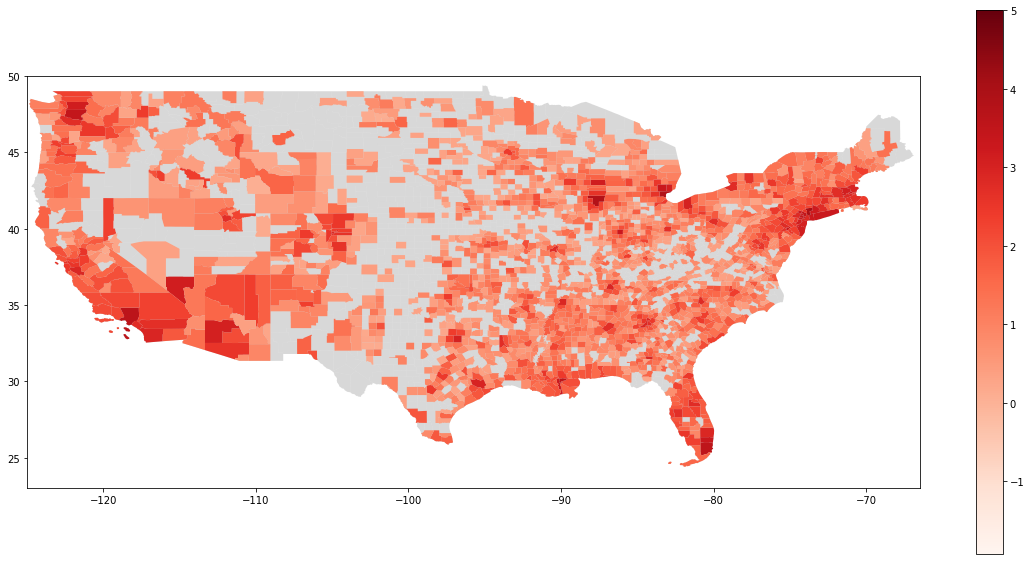

In [69]:
vmin=gdf_covid.cases_norm_log10.min()
vmax=5
#gdf_covid.cases_norm.max()
base = gdf_counties.plot(figsize=(20,10), color='grey', alpha=0.3)
gdf_covid[gdf_covid.date==dates[69]].plot('cases_norm_log10', ax=base, vmin=vmin, vmax=vmax, cmap='Reds', legend=True)
pl.xlim(-125, -66.5)
pl.ylim(23,50)
#pl.xlim(-76, -71)
#pl.ylim(39.5, 42.5)
#pl.text(--67, 24, str(dates[67])[:10], fontsize=14)

In [64]:
dates[68]

numpy.datetime64('2020-03-29T00:00:00.000000000')

vmin=gdf_covid.cases_norm_log10.min()
vmax=gdf_covid.cases_norm_log10.max()
for i in range(65, len(dates)):
    base = gdf_counties.plot(figsize=(20,10), color='grey', alpha=0.3)
    gdf_covid[gdf_covid.date==dates[i]].plot('cases_norm_log10', ax=base, vmin=vmin, vmax=vmax, cmap='Reds')
    pl.xlim(-125, -66.5)
    pl.ylim(23,50)
    #pl.xlim(-76, -71)
    #pl.ylim(39.5, 42.5)
    #pl.text(-71.7, 39.7, str(dates[i])[:10], fontsize=14)
    pl.text(-75, 25, str(dates[i])[:10], fontsize=14)
    pl.savefig('viz/' + str(dates[i]) + '.png', dpi=100, bbox_inches = 'tight')
    pl.close();

In [ ]:
df_covid[df_covid.county=='New York City']

### testing

In [ ]:
df_covid[df_]

In [ ]:
r = requests.get('https:')